In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
from torch import optim
from torch.utils.data import DataLoader, random_split


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.synchronize()






Using device: cuda:0


c:\USERS\ANTON\APPDATA\LOCAL\PROGRAMS\PYTHON\PYTHON312\Lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [2]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.device_count())  # Should be > 0
print(torch.cuda.get_device_name(0))  # Prints your GPU name

True
1
NVIDIA GeForce RTX 2050


## TASK 1


In [8]:


# Define the transform to convert images to tensor and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download the *full* training set
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

# Specify the split sizes (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

generator=torch.Generator().manual_seed(42)

# Use random_split to create training and validation datasets
# Set a manual seed for reproducible splits
train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size], generator=generator
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True, 
    num_workers=4
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=128,
    shuffle=False, 
    num_workers=4
)

# Download and load the testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4)




In [25]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)  # Assuming 32x32 input images
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [11]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.Tanh()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)  # Assuming 32x32 input images
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [12]:






# Initialize TensorBoard writer
writer = SummaryWriter()
print("TensorBoard writer created")

# Initialize model, loss function, and optimizer
model = Net2().to(device)
criterion = nn.CrossEntropyLoss().to(device)  # Ensure loss function is on GPU
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss_history = []
val_loss_history = []
best_val_accuracy = 0.0  # Track the best validation accuracy
num_epochs = 15

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # ------------------------
    #       TRAINING
    # ------------------------
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        print("Batch", i+1, end='\r')  # Just to see progress
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Accumulate training loss
        running_loss += loss.item()
    
    # Average training loss
    epoch_train_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)
    
    # Training accuracy
    train_accuracy = 100.0 * train_correct / train_total

    # Log training loss and accuracy
    writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    # ------------------------
    #      VALIDATION
    # ------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Average validation loss
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    # Validation accuracy
    val_accuracy = 100.0 * val_correct / val_total

    # Log validation loss and accuracy
    writer.add_scalar('Loss/Val', val_loss, epoch)
    writer.add_scalar('Accuracy/Val', val_accuracy, epoch)

    # Save the best model based on validation accuracy
    if epoch == 0 or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, 'cloudclass.pth')

    # Print epoch summary
    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"| Train Loss: {epoch_train_loss:.2f} "
        f"| Train Acc: {train_accuracy:.2f}% "
        f"| Val Loss: {val_loss:.2f} "
        f"| Val Acc: {val_accuracy:.2f}%"
    )

# ------------------------
#       FINAL TEST
# ------------------------
# Load the best weights from validation
model.load_state_dict(best_model_wts)
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100.0 * test_correct / test_total

writer.add_scalar('Loss/Test_Final', test_loss, num_epochs)
writer.add_scalar('Accuracy/Test_Final', test_accuracy, num_epochs)
print(f"\nFinal Test Loss: {test_loss:.2f} | Final Test Accuracy: {test_accuracy:.2f}%")

# Close the TensorBoard writer
writer.close()


TensorBoard writer created
Epoch 1/15
Epoch 1/15 | Train Loss: 1.89 | Train Acc: 34.75% | Val Loss: 1.75 | Val Acc: 39.63%
Epoch 2/15
Epoch 2/15 | Train Loss: 1.70 | Train Acc: 41.73% | Val Loss: 1.66 | Val Acc: 43.81%
Epoch 3/15
Epoch 3/15 | Train Loss: 1.63 | Train Acc: 44.40% | Val Loss: 1.60 | Val Acc: 45.19%
Epoch 4/15
Epoch 4/15 | Train Loss: 1.57 | Train Acc: 46.15% | Val Loss: 1.55 | Val Acc: 47.16%
Epoch 5/15
Epoch 5/15 | Train Loss: 1.53 | Train Acc: 47.48% | Val Loss: 1.52 | Val Acc: 47.96%
Epoch 6/15
Epoch 6/15 | Train Loss: 1.50 | Train Acc: 48.59% | Val Loss: 1.49 | Val Acc: 48.54%
Epoch 7/15
Epoch 7/15 | Train Loss: 1.47 | Train Acc: 49.66% | Val Loss: 1.47 | Val Acc: 49.22%
Epoch 8/15
Epoch 8/15 | Train Loss: 1.44 | Train Acc: 50.59% | Val Loss: 1.45 | Val Acc: 49.33%
Epoch 9/15
Epoch 9/15 | Train Loss: 1.42 | Train Acc: 51.51% | Val Loss: 1.43 | Val Acc: 50.92%
Epoch 10/15
Epoch 10/15 | Train Loss: 1.40 | Train Acc: 52.25% | Val Loss: 1.41 | Val Acc: 51.36%
Epoch 11/15

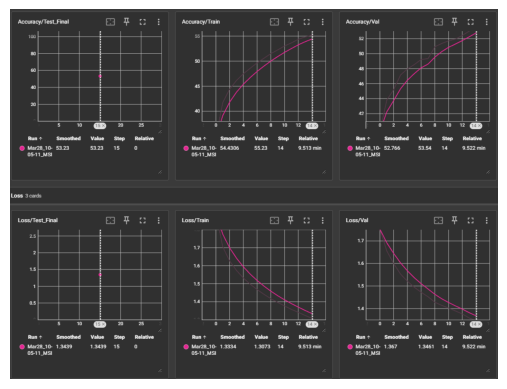

In [20]:
import matplotlib.pyplot as plt
import cv2

# Load the image (convert BGR to RGB for proper display)
image = cv2.imread("C:/Users/anton/Documents/GitHub/D7047E_lab/lab 0/image/leaky-tanh.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

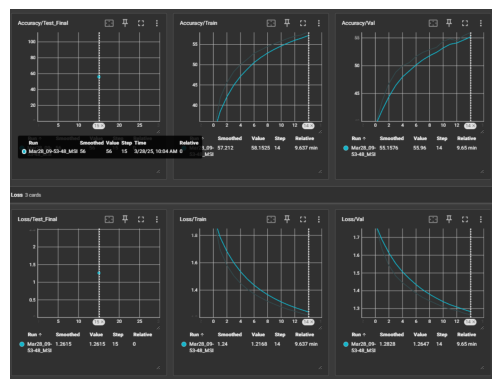

In [21]:
# Load the image (convert BGR to RGB for proper display)
image = cv2.imread("C:/Users/anton/Documents/GitHub/D7047E_lab/lab 0/image/leaky+ADAM.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

## Task 2

### Task 2.1


In [15]:
from torchvision.models import alexnet, AlexNet_Weights

# Load the pre-trained AlexNet model
alexnet_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
print(alexnet_model.classifier)
alexnet_model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

# Modify the classifier to have 10 output neurons
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, 10)



Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [16]:






# Initialize TensorBoard writer
writer = SummaryWriter()
print("TensorBoard writer created")

# Initialize model, loss function, and optimizer
model = alexnet_model.to(device)
criterion = nn.CrossEntropyLoss().to(device)  # Ensure loss function is on GPU
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss_history = []
val_loss_history = []
best_val_accuracy = 0.0  # Track the best validation accuracy
num_epochs = 15

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # ------------------------
    #       TRAINING
    # ------------------------
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        print("Batch", i+1, end='\r')  # Just to see progress
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Accumulate training loss
        running_loss += loss.item()
    
    # Average training loss
    epoch_train_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)
    
    # Training accuracy
    train_accuracy = 100.0 * train_correct / train_total

    # Log training loss and accuracy
    writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    # ------------------------
    #      VALIDATION
    # ------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Average validation loss
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    # Validation accuracy
    val_accuracy = 100.0 * val_correct / val_total

    # Log validation loss and accuracy
    writer.add_scalar('Loss/Val', val_loss, epoch)
    writer.add_scalar('Accuracy/Val', val_accuracy, epoch)

    # Save the best model based on validation accuracy
    if epoch == 0 or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, 'cloudclass.pth')

    # Print epoch summary
    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"| Train Loss: {epoch_train_loss:.2f} "
        f"| Train Acc: {train_accuracy:.2f}% "
        f"| Val Loss: {val_loss:.2f} "
        f"| Val Acc: {val_accuracy:.2f}%"
    )

# ------------------------
#       FINAL TEST
# ------------------------
# Load the best weights from validation
model.load_state_dict(best_model_wts)
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100.0 * test_correct / test_total

writer.add_scalar('Loss/Test_Final', test_loss, num_epochs)
writer.add_scalar('Accuracy/Test_Final', test_accuracy, num_epochs)
print(f"\nFinal Test Loss: {test_loss:.2f} | Final Test Accuracy: {test_accuracy:.2f}%")

# Close the TensorBoard writer
writer.close()


TensorBoard writer created
Epoch 1/15
Epoch 1/15 | Train Loss: 1.41 | Train Acc: 48.56% | Val Loss: 1.13 | Val Acc: 59.29%
Epoch 2/15
Epoch 2/15 | Train Loss: 1.04 | Train Acc: 62.45% | Val Loss: 1.01 | Val Acc: 63.78%
Epoch 3/15
Epoch 3/15 | Train Loss: 0.87 | Train Acc: 68.99% | Val Loss: 0.92 | Val Acc: 66.85%
Epoch 4/15
Epoch 4/15 | Train Loss: 0.74 | Train Acc: 73.67% | Val Loss: 0.81 | Val Acc: 71.20%
Epoch 5/15
Epoch 5/15 | Train Loss: 0.62 | Train Acc: 77.94% | Val Loss: 0.78 | Val Acc: 72.69%
Epoch 6/15
Epoch 6/15 | Train Loss: 0.52 | Train Acc: 81.67% | Val Loss: 0.78 | Val Acc: 73.65%
Epoch 7/15
Epoch 7/15 | Train Loss: 0.44 | Train Acc: 84.27% | Val Loss: 0.77 | Val Acc: 74.56%
Epoch 8/15
Epoch 8/15 | Train Loss: 0.36 | Train Acc: 87.10% | Val Loss: 0.79 | Val Acc: 74.83%
Epoch 9/15
Epoch 9/15 | Train Loss: 0.29 | Train Acc: 89.80% | Val Loss: 0.83 | Val Acc: 74.47%
Epoch 10/15
Epoch 10/15 | Train Loss: 0.24 | Train Acc: 91.61% | Val Loss: 0.84 | Val Acc: 75.36%
Epoch 11/15

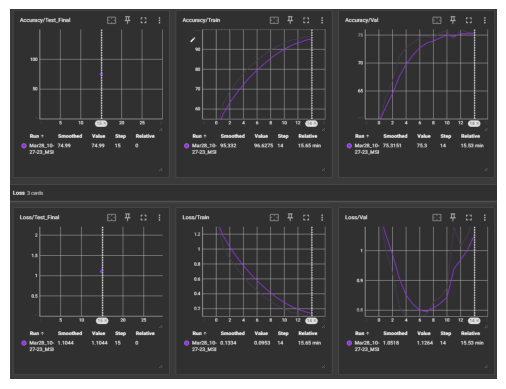

In [22]:
# Load the image (convert BGR to RGB for proper display)
image = cv2.imread("C:/Users/anton/Documents/GitHub/D7047E_lab/lab 0/image/alexnet.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

### Task 2.2


In [49]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Change input channels to 1
        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 14, 10)  # Adjust input features for 28x28 input images
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [23]:

# Define the transform to convert images to tensor and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization values for MNIST
])

# Download the *full* training set
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

# Specify the split sizes (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)

# Use random_split to create training and validation datasets
train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size], generator=generator
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True, 
    num_workers=4
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=128,
    shuffle=False, 
    num_workers=4
)

# Download and load the testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=128,
                         shuffle=False, num_workers=4)


100%|██████████| 9.91M/9.91M [00:20<00:00, 495kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 124kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.00MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [50]:
# Initialize TensorBoard writer
writer = SummaryWriter()
print("TensorBoard writer created")

# Initialize model, loss function, and optimizer
model = Net3().to(device)
criterion = nn.CrossEntropyLoss().to(device)  # Ensure loss function is on GPU
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loss_history = []
val_loss_history = []
best_val_accuracy = 0.0  # Track the best validation accuracy
num_epochs = 15

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # ------------------------
    #       TRAINING
    # ------------------------
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        print("Batch", i+1, end='\r')  # Just to see progress
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Accumulate training loss
        running_loss += loss.item()
    
    # Average training loss
    epoch_train_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)
    
    # Training accuracy
    train_accuracy = 100.0 * train_correct / train_total

    # Log training loss and accuracy
    writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    # ------------------------
    #      VALIDATION
    # ------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Average validation loss
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    # Validation accuracy
    val_accuracy = 100.0 * val_correct / val_total

    # Log validation loss and accuracy
    writer.add_scalar('Loss/Val', val_loss, epoch)
    writer.add_scalar('Accuracy/Val', val_accuracy, epoch)

    # Save the best model based on validation accuracy
    if epoch == 0 or val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, 'mnistmodel.pth')

    # Print epoch summary
    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"| Train Loss: {epoch_train_loss:.2f} "
        f"| Train Acc: {train_accuracy:.2f}% "
        f"| Val Loss: {val_loss:.2f} "
        f"| Val Acc: {val_accuracy:.2f}%"
    )

# ------------------------
#       FINAL TEST
# ------------------------
# Load the best weights from validation
model.load_state_dict(torch.load('mnistmodel.pth'))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100.0 * test_correct / test_total

writer.add_scalar('Loss/Test_Final', test_loss, num_epochs)
writer.add_scalar('Accuracy/Test_Final', test_accuracy, num_epochs)
print(f"\nFinal Test Loss: {test_loss:.2f} | Final Test Accuracy: {test_accuracy:.2f}%")

# Close the TensorBoard writer
writer.close()

TensorBoard writer created
Epoch 1/15
Epoch 1/15 | Train Loss: 2.22 | Train Acc: 20.18% | Val Loss: 2.17 | Val Acc: 21.55%
Epoch 2/15
Epoch 2/15 | Train Loss: 2.11 | Train Acc: 26.42% | Val Loss: 2.04 | Val Acc: 31.40%
Epoch 3/15
Epoch 3/15 | Train Loss: 1.95 | Train Acc: 36.12% | Val Loss: 1.88 | Val Acc: 39.33%
Epoch 4/15
Epoch 4/15 | Train Loss: 1.79 | Train Acc: 45.13% | Val Loss: 1.72 | Val Acc: 49.30%
Epoch 5/15
Epoch 5/15 | Train Loss: 1.64 | Train Acc: 52.30% | Val Loss: 1.59 | Val Acc: 52.44%
Epoch 6/15
Epoch 6/15 | Train Loss: 1.50 | Train Acc: 57.64% | Val Loss: 1.46 | Val Acc: 58.44%
Epoch 7/15
Epoch 7/15 | Train Loss: 1.39 | Train Acc: 61.92% | Val Loss: 1.35 | Val Acc: 62.12%
Epoch 8/15
Epoch 8/15 | Train Loss: 1.29 | Train Acc: 64.85% | Val Loss: 1.28 | Val Acc: 64.84%
Epoch 9/15
Epoch 9/15 | Train Loss: 1.22 | Train Acc: 67.25% | Val Loss: 1.21 | Val Acc: 67.56%
Epoch 10/15
Epoch 10/15 | Train Loss: 1.15 | Train Acc: 69.07% | Val Loss: 1.15 | Val Acc: 68.24%
Epoch 11/15

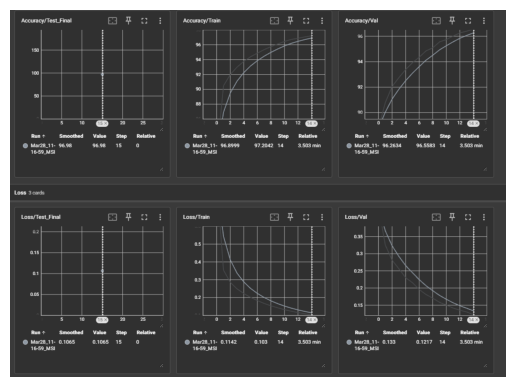

In [31]:
# Load the image (convert BGR to RGB for proper display)
image = cv2.imread("C:/Users/anton/Documents/GitHub/D7047E_lab/lab 0/image/mnist.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

### SVHN

In [51]:


# Define the transform to convert images to tensor and normalize them
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalization values for MNIST (since the dataset is now grayscale)
])

# Download the *full* training set
full_train_dataset = torchvision.datasets.SVHN(
    root='./data', 
    split='train',
    download=True, 
    transform=transform
)

# Specify the split sizes (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)

# Use random_split to create training and validation datasets
train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size], generator=generator
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True, 
    num_workers=4
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=128,
    shuffle=False, 
    num_workers=4
)

# Download and load the testing dataset
testset = torchvision.datasets.SVHN(root='./data', split='test',
                                     download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=128,
                         shuffle=False, num_workers=4)


In [52]:
model = Net3().to(device)
model.load_state_dict(torch.load('mnistmodel.pth'))
writer = SummaryWriter()



test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100.0 * test_correct / test_total

writer.add_scalar('Loss/Test_Final', test_loss, num_epochs)
writer.add_scalar('Accuracy/Test_Final', test_accuracy, num_epochs)
print(f"\nFinal Test Loss: {test_loss:.2f} | Final Test Accuracy: {test_accuracy:.2f}%")
writer.close()


Final Test Loss: 1.00 | Final Test Accuracy: 73.11%
